In [127]:
from pymongo import MongoClient
from methods import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from torchvision import datasets
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [128]:
mongo_server_name = "mongodb://192.168.200.1:27021/"
mongo_database_name = "WPE_links"
mongo_collection_name = "Blocks"
client_posts_collection = MongoClient(mongo_server_name)[mongo_database_name][mongo_collection_name]

In [ ]:
posts = client_posts_collection.find()
post = posts[0]

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
X_classical, y_classical, X, y, labels_list, bbox = get_all_data(client_posts_collection, 300)

100%|█████████▉| 299/300 [01:35<00:00,  3.15it/s]


**--------------------------------------------------------------**

In [2]:
# mongo_server_name = "mongodb://192.168.200.1:27021/"
# mongo_database_name = "WPE_test_2022"
# mongo_collection_name = "Blocks"

In [3]:
# url = "https://www.vedomosti.ru/business/articles/2022/04/01/916299-gazprom-poteryal-kontrol-evropeiskimi-phg"

In [4]:
# client_posts_collection = MongoClient(mongo_server_name)[mongo_database_name][mongo_collection_name]

In [5]:
# post = client_posts_collection.find_one(
#                      {"URL": url}, {"Blocks": 1, "Image": 1, "MatchingBlocks": 1}
#                  )

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
all_blocks = []
for block_body in post["Blocks"].values():
    all_blocks.append(block_body)
image_size = (post["Image"]["width"], post["Image"]["height"])
cell_map = prepare_map_irreg(image_size, all_blocks)

In [37]:
X, y = [], []
cut_size=(512, 256)
labels_list, bbox = [], []
X, y, labels_list, bbox, xs, ys = get_nn_dataset(image_size, all_blocks, cell_map,
                                                 X, y, labels_list, bbox, cut_size)

In [40]:
new_lst = [list(x) for x in zip(xs, ys)]
all1 = [list(x) for x in zip(np.arange(512), np.arange(256))]
new_lst = np.array(new_lst)
all1 = np.array(all1)

<function matplotlib.pyplot.show(close=None, block=None)>

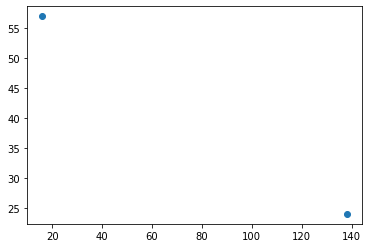

In [109]:
plt.scatter([ 16, 138],  [57,  24])#, c = clusters)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

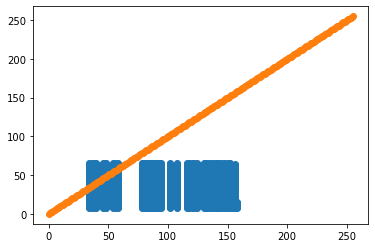

In [43]:
import matplotlib.pyplot as plt
plt.scatter(new_lst[:, 0], new_lst[:,1])#, c = clusters)
plt.scatter(all1[:, 0], all1[:,1])
plt.show

**--------------------------------------------------------------**

In [136]:
bbox2 = []
for i in range(len(bbox)):
    bbox2.append([[bbox[i][0][0], bbox[i][0][3], bbox[i][0][2], bbox[i][0][1]]])

In [138]:
from torch.nn.utils.rnn import pad_sequence
bbox1 = pad_sequence([torch.tensor(x) for x in bbox2], batch_first=True)

In [74]:
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
#X, y = get_classical_dataset(all_blocks)
X_train, X_test, y_train, y_test = train_test_split(X_classical, y_classical, test_size=0.33, random_state=42)
clf = CatBoostClassifier(logging_level='Silent')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
average_precision_score(y_test, y_pred)

0.7027790593196307

In [105]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)


D:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
modul = np.abs(lr.coef_)
best_weight = list(pd.DataFrame(modul).T.sort_values(by = 0, ascending=False).head(4).index)

In [112]:
X_train.iloc[:, best_weight].columns

Index(['font_size', 'lenght', 'size_2', 'size_1'], dtype='object')

In [24]:
# image_size = (post["Image"]["width"], post["Image"]["height"])
# my_map = prepare_map_irreg(image_size, filtered_blocks)

In [118]:
# cell_map = prepare_map_irreg(image_size, filtered_blocks)
# X, y = [], [] 
# labels_list, bbox = [], []
# cut_size=(512, 256)
             

# X, y, labels_list, bbox = get_nn_dataset(image_size, filtered_blocks, cell_map,
#                                              X, y, labels_list, bbox, cut_size)

In [172]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [173]:
class MyDataset_web_page(torch.utils.data.Dataset):
    def __init__(self, data, labels_list, bbox):
        super().__init__()
        self.data = data
        self.labels_list = labels_list
        self.bbox = bbox
    
    def __getitem__(self, idx):
        page = self.data[idx]
        labels = self.labels_list[idx]
        bbox = self.bbox[idx]
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        iscrowd = torch.zeros((bbox.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        return torch.from_numpy(page), target
    
    def __len__(self):
        return len(self.data)

In [180]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_bbox, test_bbox, train_labels_list, test_labels_list = train_test_split(bbox1, labels_list, test_size=0.33, random_state=42)

In [181]:
batch_size = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_dataset = MyDataset_web_page(X_train, train_labels_list, train_bbox)
valid_dataset = MyDataset_web_page(X_test, test_labels_list, test_bbox)

train_dataloader =  torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [182]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [183]:
from tqdm.auto import tqdm
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [184]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [185]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
import time
model = create_model(num_classes=2)
model.double()
#model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(
    params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(2):
    print(f"\nEPOCH {epoch+1} of {2}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # create two subplots, one for each, training and validation
    start = time.time()
    train_loss = train(train_dataloader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")


EPOCH 1 of 2
Training


  0%|          | 0/34 [00:00<?, ?it/s]